# <center>基于变分原理神经网络的 Poisson 方程求解</center>

### <center>孙琪, 《应用与计算数学前沿讲座》，2024秋

## 1. 问题描述
**古典形式：** 寻找一个函数 $u(x)\in C^2(\Omega)\cap C(\bar{\Omega})$ 满足

\begin{equation*}
\begin{array}{cl}
- \Delta u(x) = f(x)\ \ & \text{in}\ \Omega,\\
u(x)=g(x)\ \ & \text{on}\ \partial \Omega\setminus\Gamma,\\
\nabla u(x)\cdot n = h(x)\ \ & \text{on}\ \Gamma.
\end{array}
\end{equation*}

通过引入惩罚系数 $\beta>0$, 上述方程的解同样也满足下述优化问题

\begin{equation*}
	\min_{u\in C^2(\Omega)\cap C(\bar{\Omega})} \int_\Omega | -\Delta u - f |^2 dx + \beta \left( \int_{\partial\Omega\setminus\Gamma} | u - g |^2 ds + \int_{\Gamma} |\nabla u\cdot n - h|^2 ds \right).
\end{equation*}

**Ritz 形式：** 在变分理论的框架下，Poisson 方程的弱解也是如下能量泛函的最优解，即 

\begin{equation*}
	\min_{u\in H^1_{\partial\Omega\setminus\Gamma,g}(\Omega)} \int_\Omega \Big( \frac12 |\nabla u|^2 - fu\Big)dx - \int_{\Gamma} hu\, ds
\end{equation*}

通过引入惩罚系数 $\beta>0$, 上述最优化问题可以改写为

\begin{equation*}
	\min_{u\in H^1(\Omega)} \int_\Omega \Big( \frac12 |\nabla u|^2 - fu\Big)dx - \int_{\Gamma} hu \, ds + \beta \int_{\partial\Omega\setminus\Gamma} | u - g |^2 ds.
\end{equation*}

**Galerkin 形式：** 方程的弱形式还可以表达为：寻找 $u\in H^1_{\partial\Omega\setminus\Gamma,g}(\Omega):=\{ w\in H^1(\Omega): w|_{\partial\Omega\setminus\Gamma} = g \}$ 使得
    
\begin{equation*}
	\int_\Omega \nabla u\cdot\nabla v\,dx - \int_{\Gamma} hv \, ds  = \int_\Omega fv \,dx
\end{equation*}

对任意的 $v\in H^1_{\partial\Omega \setminus\Gamma,0}(\Omega)$ 成立。等价的，上述 Galerkin 形式可以写成如下的 minmax 问题（暂时不展开讨论）：


\begin{equation*}
	\min_{u\in H^1_{\partial\Omega\setminus\Gamma,g}(\Omega)} \max_{v\in H^1_{\partial\Omega \setminus\Gamma,0}(\Omega)} \left( \int_\Omega \big( \nabla u\cdot\nabla v - fv \big) dx - \int_{\Gamma} hv \, ds \right)^2 / \int_\Omega |v|^2 dx.
\end{equation*}


## 2. 变分原理神经网络方法

<center><img src="figures//PINNs-EllipticPDE-Soft.jpg" width="500"></center>

#### 函数逼近

得益于人工神经网络的通用逼近性质
- 任意复杂的函数或算子都可以通过一个适当的人工神经网络来表示或逼近
- The Universal Approximation Theorem (1989): Neural Networks are capable of approximating any Borel measurable function
  
<center><img src="figures//universal-approximator.jpg" width="500"></center>

我们使用一个全连接网络（fully-connected neural network）来参数化未知函数，其中神经网络的待定参数用 $\theta$ 表示，即

$$
u(x)\approx u_{\mathrm{NN}}(x;\theta).
$$

#### 优化问题

通过 Monte Carlo 方法将积分进行离散，得到计算区域内部和边界的样本点 $ X_{\mathrm{intrr}} = \{x^\Omega_i\}_{i=1}^{N_\Omega}$，$X_D = \{x^D_i\}_{i=1}^{N_D}$ 和 $X_\Gamma = \{x^\Gamma_i\}_{i=1}^{N_\Gamma}$，我们得到机器学习所对应的优化问题

\begin{equation*}
	\theta^* = \operatorname*{arg\,min}_{\theta} \frac{1}{N_\Omega}\sum_{i=1}^{N_\Omega} \Big( \frac12 |\nabla u_{\mathrm{NN}}(x_i^\Omega;\theta) |^2 - f(x_i^\Omega)u_{\mathrm{NN}}(x_i^\Omega;\theta) \Big) - \frac{1}{N_\Gamma}\sum_{i=1}^{N_\Gamma} h(x_i^\Gamma)u_{\mathrm{NN}}(x_i^\Gamma;\theta) + \frac{\beta}{N_D} \sum_{i=1}^{N_D} | u_{\mathrm{NN}}(x_i^D;\theta) - g(x_i^D) |^2
\end{equation*}

相比于物理信息神经网络方法，此处无需求二阶导数，因此在计算代价上有所改善。

#### 自动微分

自动微分技术 **Auto Differentiation**（[`torch.autograd`](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd)）可以用来精确计算模型解关于输入变量的导数，进而用于构造损失函数。

<center><img src="figures//fig-AD.jpg" width="500"></center>

#### 随机优化

对于这种**输入样本数量巨大**、**训练参数个数较多** 以及 **优化问题高度非凸**，通常会采用[随机梯度下降方法](https://epubs.siam.org/doi/10.1137/16M1080173)**（Stochastic Gradient Descent）**及其变形作为迭代求解算法。

<center><img src="figures//fig-SGD.jpg" width="400"></center>


## 3. 算例及编程

**二维 Poisson 方程:** 考虑下述二阶椭圆边值问题

\begin{equation*}
\begin{array}{cl}
- \Delta u(x) = 4\pi^2\sin(2\pi x)(2\cos(2\pi y)-1)\ \ & \text{in}\ \Omega=(0,1)^2,\\
u(x)=0\ \ & \text{on}\ \partial\Omega\setminus\Gamma=(0,0)\ \text{to}\ (1,0)\ \text{to}\ (1,1)\ \text{to}\ (0,1),\\
\nabla u(x)\cdot n = -2\pi \cos(2\pi x) ( \cos(2\pi y) - 1)\ \ & \text{on}\ \Gamma= (0,0)\ \text{to}\ (0,1),
\end{array}
\end{equation*}

其解析解的表达式为

\begin{equation}
u(x,y)=\sin(2\pi x)(\cos(2\pi y)-1).
\end{equation}


In [1]:
##############################################################################################
import torch
import torch.nn as nn
import numpy as np
import os
import time
import datetime
import argparse 

from torch import optim, autograd
from matplotlib import pyplot as plt

# create training and testing datasets
from torch.utils.data import Dataset, DataLoader
from DataSets.Square2D import Sample_Points, Exact_Solution

# create neural network surrogate model
from Models.FcNet import FcNet

# load data from two datasets within the same loop
from itertools import cycle

print("pytorch version", torch.__version__, "\n")
##############################################################################################


##############################################################################################
## hyperparameter configuration
## ------------------------- ##
# problem setting
dim_prob = 2
bndry_type = 2 # Neumann boundary on Gamma
## ------------------------- ##
# dataset setting
num_intrr_pts = 100000
num_bndry_pts_D = 10000 # each line segment of Dirichlet boundary
num_bndry_pts_G = 10000 # line segment of Dirichlet boundary (Gamma)
num_test_pts = 100 # each dimension

batch_num = 10 # for the ease of dataloader, require interior and boundary points have the same number of mini-batches
batchsize_intrr_pts = num_intrr_pts // batch_num
batchsize_bndry_pts_D = 3*num_bndry_pts_D // batch_num
batchsize_bndry_pts_G = num_bndry_pts_G // batch_num
## ------------------------- ##
# network setting
width = 20
depth = 3
## ------------------------- ##
# optimization setting
beta = 400 # intial penalty coefficient
num_epochs = 750
milestones = 400, 600, 700
##############################################################################################


##############################################################################################
print('*', '-' * 45, '*')
print('===> preparing training and testing datasets ...')
print('*', '-' * 45, '*')

# training dataset for sample points inside the domain
class TraindataInterior(Dataset):    
    def __init__(self, num_intrr_pts, dim_prob): 
        
        self.SmpPts_Interior = Sample_Points.SmpPts_Interior_Square2D(num_intrr_pts, dim_prob)
        self.f_Exact_SmpPts = Exact_Solution.f_Exact_Square2D(self.SmpPts_Interior[:,0], self.SmpPts_Interior[:,1])        
               
    def __len__(self):
        return len(self.SmpPts_Interior)
    
    def __getitem__(self, idx):
        SmpPt = self.SmpPts_Interior[idx]
        f_SmpPt = self.f_Exact_SmpPts[idx]

        return [SmpPt, f_SmpPt]
    
# training dataset for sample points at the Dirichlet boundary
class TraindataBoundaryDirichlet(Dataset):    
    def __init__(self, num_bndry_pts_D, dim_prob):         
        
        self.SmpPts_Bndry_D = Sample_Points.SmpPts_Boundary_Square2D(num_bndry_pts_D, dim_prob)
        self.g_SmpPts = Exact_Solution.g_Exact_Square2D(self.SmpPts_Bndry_D[:,0], self.SmpPts_Bndry_D[:,1])        
        
    def __len__(self):
        return len(self.SmpPts_Bndry_D)
    
    def __getitem__(self, idx):
        SmpPt = self.SmpPts_Bndry_D[idx]
        g_SmpPt = self.g_SmpPts[idx]

        return [SmpPt, g_SmpPt]    
    
# training dataset for sample points at the Neumann boundary
class TraindataGamma(Dataset):    
    def __init__(self, bndry_type, num_bndry_pts_G, dim_prob):         
        
        self.SmpPts_Bndry_G = Sample_Points.SmpPts_Interface_Square2D(num_bndry_pts_G, dim_prob)
        self.h_SmpPts = Exact_Solution.h_Exact_Square2D(bndry_type, self.SmpPts_Bndry_G[:,0], self.SmpPts_Bndry_G[:,1])        
        
    def __len__(self):
        return len(self.SmpPts_Bndry_G)
    
    def __getitem__(self, idx):
        SmpPt = self.SmpPts_Bndry_G[idx]
        h_SmpPt = self.h_SmpPts[idx]

        return [SmpPt, h_SmpPt]    
    
# testing dataset for equidistant sample points over the entire domain
class Testdata(Dataset):    
    def __init__(self, num_test_pts): 
        
        self.SmpPts_Test = Sample_Points.SmpPts_Test_Square2D(num_test_pts)
        self.u_Exact_SmpPts = Exact_Solution.u_Exact_Square2D(self.SmpPts_Test[:,0], self.SmpPts_Test[:,1])        
        self.dudx_Exact_SmpPts = Exact_Solution.dudx_Exact_Square2D(self.SmpPts_Test[:,0], self.SmpPts_Test[:,1])
        self.dudy_Exact_SmpPts = Exact_Solution.dudy_Exact_Square2D(self.SmpPts_Test[:,0], self.SmpPts_Test[:,1])         
                 
    def __len__(self):
        return len(self.SmpPts_Test)
    
    def __getitem__(self, idx):
        SmpPt = self.SmpPts_Test[idx]
        u_Exact_SmpPt = self.u_Exact_SmpPts[idx]
        dudx_Exact_SmpPt = self.dudx_Exact_SmpPts[idx]
        dudy_Exact_SmpPt = self.dudy_Exact_SmpPts[idx]
 
        return [SmpPt, u_Exact_SmpPt, dudx_Exact_SmpPt, dudy_Exact_SmpPt] 
    
# create training and testing datasets         
traindata_intrr = TraindataInterior(num_intrr_pts, dim_prob)
traindata_bndry_D = TraindataBoundaryDirichlet(num_bndry_pts_D, dim_prob)
traindata_bndry_G = TraindataGamma(bndry_type, num_bndry_pts_G, dim_prob)
testdata = Testdata(num_test_pts)

# define dataloader 
dataloader_intrr = DataLoader(traindata_intrr, batch_size=batchsize_intrr_pts, shuffle=True, num_workers=0)
dataloader_bndry_D = DataLoader(traindata_bndry_D, batch_size=batchsize_bndry_pts_D, shuffle=True, num_workers=0)
dataloader_bndry_G = DataLoader(traindata_bndry_G, batch_size=batchsize_bndry_pts_G, shuffle=True, num_workers=0)
dataloader_test = DataLoader(testdata, batch_size=num_test_pts*num_test_pts, shuffle=False, num_workers=0)
##############################################################################################

pytorch version 2.4.0 

* --------------------------------------------- *
===> preparing training and testing datasets ...
* --------------------------------------------- *


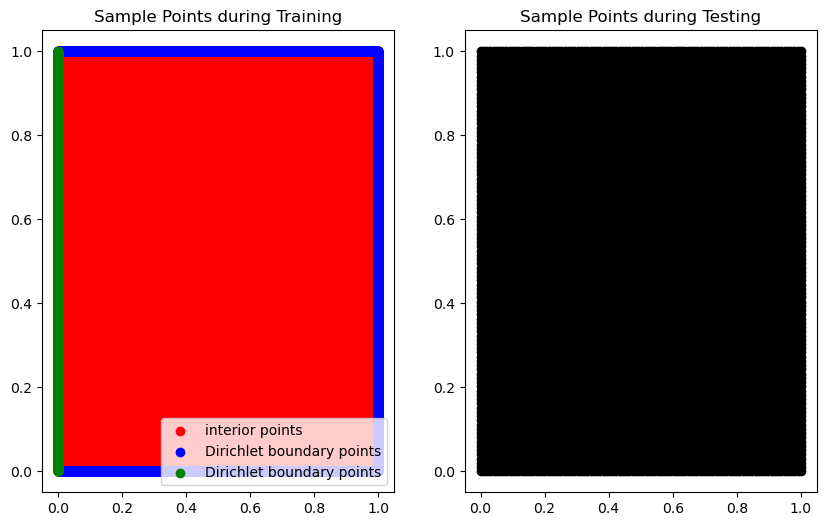

In [2]:
# plot sample points during training and testing

fig = plt.figure(figsize=(10, 6), dpi= 100)
plt.subplot(1, 2, 1)
plt.scatter(traindata_intrr.SmpPts_Interior[:,0], traindata_intrr.SmpPts_Interior[:,1], c = 'red', label = 'interior points' )
plt.scatter(traindata_bndry_D.SmpPts_Bndry_D[:,0], traindata_bndry_D.SmpPts_Bndry_D[:,1], c = 'blue', label = 'Dirichlet boundary points' )
plt.scatter(traindata_bndry_G.SmpPts_Bndry_G[:,0], traindata_bndry_G.SmpPts_Bndry_G[:,1], c = 'green', label = 'Dirichlet boundary points' )
plt.title('Sample Points during Training')
plt.legend(loc = 'lower right')

plt.subplot(1, 2, 2)
plt.scatter(testdata.SmpPts_Test[:,0], testdata.SmpPts_Test[:,1], c = 'black')
plt.title('Sample Points during Testing')

plt.show()

In [3]:
##############################################################################################
print('*', '-' * 45, '*')
print('===> creating training model ...')
print('*', '-' * 45, '*', "\n", "\n")

def train_epoch(model, optimizer, device):
    
    # set model to training mode
    model.train()

    # ideally, sample points within the interior domain and at its boundary have the same number of mini-batches
    # otherwise, it wont's shuffle the dataloader_boundary samples again when it starts again (see https://discuss.pytorch.org/t/two-dataloaders-from-two-different-datasets-within-the-same-loop/87766/7)
    for i, (data_intrr, data_bndry_D, data_bndry_G) in enumerate(zip(dataloader_intrr, cycle(dataloader_bndry_D), cycle(dataloader_bndry_G))):
        
        # get mini-batch training data
        smppts_intrr, f_smppts = data_intrr
        smppts_bndry_D, g_smppts = data_bndry_D
        smppts_bndry_G, h_smppts = data_bndry_G
        # send training data to device
        smppts_intrr = smppts_intrr.to(device)
        f_smppts = f_smppts.to(device)
        smppts_bndry_D = smppts_bndry_D.to(device)
        g_smppts = g_smppts.to(device)
        smppts_bndry_G = smppts_bndry_G.to(device)
        h_smppts = h_smppts.to(device)
        
        smppts_intrr.requires_grad = True
        
        # forward pass to obtain NN prediction of u(x)
        u_NN_intrr = model(smppts_intrr)
        u_NN_bndry_D = model(smppts_bndry_D)
        u_NN_bndry_G = model(smppts_bndry_G)
        # zero parameter gradients and then compute NN prediction of gradient u(x)
        model.zero_grad()
        grad_u_NN_intrr = torch.autograd.grad(outputs=u_NN_intrr, inputs=smppts_intrr, grad_outputs = torch.ones_like(u_NN_intrr), retain_graph=True, create_graph=True, only_inputs=True)[0]                                        
               
        # construct mini-batch loss function and then perform backward pass
        loss_intrr = torch.mean(0.5 * torch.sum(torch.pow(grad_u_NN_intrr, 2), dim=1) - f_smppts * torch.squeeze(u_NN_intrr))
        loss_bndry_D = torch.mean(torch.pow(torch.squeeze(u_NN_bndry_D) - g_smppts, 2))
        loss_bndry_G = torch.mean(torch.squeeze(u_NN_bndry_G) * h_smppts)
                                       
        loss_minibatch = loss_intrr - loss_bndry_G + beta * loss_bndry_D

        # zero parameter gradients
        optimizer.zero_grad()
        # backpropagation
        loss_minibatch.backward()
        # parameter update
        optimizer.step()                               
        
    return loss_minibatch
##############################################################################################


##############################################################################################
print('*', '-' * 45, '*')
print('===> creating testing model ...')
print('*', '-' * 45, '*', "\n", "\n")

def test_epoch(model, optimizer, device):
    
    # set model to testing mode
    model.eval()

    for smppts_test, u_exact_smppts, dudx_exact_smppts, dudy_exact_smppts in dataloader_test:
        
        # send inputs, outputs to device
        smppts_test = smppts_test.to(device)
        u_exact_smppts = u_exact_smppts.to(device)  
        dudx_exact_smppts = dudx_exact_smppts.to(device)
        dudy_exact_smppts = dudy_exact_smppts.to(device)
        
        smppts_test.requires_grad = True
        
        # forward pass and then compute loss function for approximating u by u_NN
        u_NN_smppts = model(smppts_test) 
        
        loss_u = torch.mean(torch.pow(torch.squeeze(u_NN_smppts) - u_exact_smppts, 2))         
        
        # backward pass to obtain gradient and then compute loss function for approximating grad_u by grad_u_NN
        model.zero_grad()
        grad_u_NN_smppts = torch.autograd.grad(outputs=u_NN_smppts, inputs=smppts_test, grad_outputs=torch.ones_like(u_NN_smppts), retain_graph=True, create_graph=True, only_inputs=True)[0]
        
        loss_dudx = torch.mean(torch.pow(torch.squeeze(grad_u_NN_smppts[:,0]) - dudx_exact_smppts, 2)) 
        loss_dudy = torch.mean(torch.pow(torch.squeeze(grad_u_NN_smppts[:,1]) - dudy_exact_smppts, 2))                
    
    return loss_u, loss_dudx, loss_dudy
##############################################################################################


##############################################################################################
print('*', '-' * 45, '*')
print('===> training neural network ...')

# create model
model = FcNet.FcNet(dim_prob,width,1,depth)
model.Xavier_initi()
print('Network Architecture:', "\n", model)
print('Total number of trainable parameters = ', sum(p.numel() for p in model.parameters() if p.requires_grad))

# create optimizer and learning rate schedular
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
schedular = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

# load model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE: {}'.format(device), "\n")
model = model.to(device)
     
# train and test 
trainloss, testloss_u, testloss_dudx, testloss_dudy = [], [], [], []

since = time.time()
for epoch in range(num_epochs):        
        
    # execute training and testing
    trainloss_epoch = train_epoch(model, optimizer, device)
    testloss_u_epoch, testloss_dudx_epoch, testloss_dudy_epoch = test_epoch(model, optimizer, device)
    
    if epoch % 100 == 0:
        print('Epoch {}/{}'.format(epoch, num_epochs-1), 'with LR = {:.1e}'.format(optimizer.param_groups[0]['lr']))  
        print('==> Full-Batch Training Loss = {:.4e}'.format(trainloss_epoch))
        print('    Fubb-Batch Testing Loss : ', 'u-u_NN = {:.4e}'.format(testloss_u_epoch), '  d(u-u_NN)dx = {:.4e}'.format(testloss_dudx_epoch), '  d(u-u_NN)dy = {:.4e}'.format(testloss_dudy_epoch), "\n")
     
    # adjust learning rate according to predefined schedule
    schedular.step()

    # print results
    trainloss.append(trainloss_epoch)
    testloss_u.append(testloss_u_epoch)
    testloss_dudx.append(testloss_dudx_epoch)
    testloss_dudy.append(testloss_dudy_epoch)

time_elapsed = time.time() - since 

print('Done in {}'.format(str(datetime.timedelta(seconds=time_elapsed))), '!')
print('*', '-' * 45, '*', "\n", "\n")
##############################################################################################

* --------------------------------------------- *
===> creating training model ...
* --------------------------------------------- * 
 

* --------------------------------------------- *
===> creating testing model ...
* --------------------------------------------- * 
 

* --------------------------------------------- *
===> training neural network ...
Network Architecture: 
 FcNet(
  (stack): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1-3): 3 x FcBlock(
      (Linear1): Linear(in_features=20, out_features=20, bias=True)
      (Linear2): Linear(in_features=20, out_features=20, bias=True)
      (activation): Tanh()
    )
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)
Total number of trainable parameters =  2601
DEVICE: cpu 

Epoch 0/749 with LR = 1.0e-02
==> Full-Batch Training Loss = 3.0864e+00
    Fubb-Batch Testing Loss :  u-u_NN = 7.1359e-01   d(u-u_NN)dx = 2.9587e+01   d(u-u_NN)dy = 9.6032e+00 

Epoch 100/749 with LR = 1.0e-02
==>

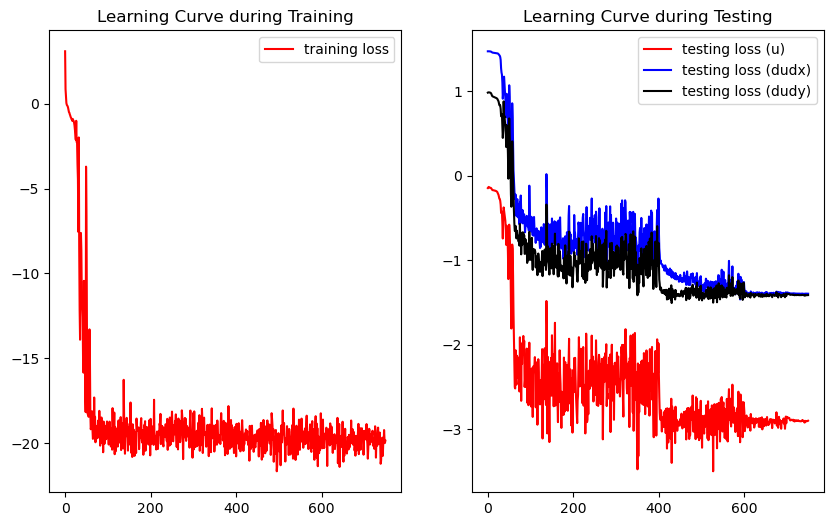

In [4]:
# plot learning curves

fig = plt.figure(figsize=(10, 6), dpi= 100)
plt.subplot(1, 2, 1)
plt.plot(torch.tensor(trainloss), c = 'red', label = 'training loss' )
plt.title('Learning Curve during Training')
plt.legend(loc = 'upper right')

plt.subplot(1, 2, 2)
plt.plot(torch.log10(torch.tensor(testloss_u)), c = 'red', label = 'testing loss (u)' )
plt.plot(torch.log10(torch.tensor(testloss_dudx)), c = 'blue', label = 'testing loss (dudx)' )
plt.plot(torch.log10(torch.tensor(testloss_dudy)), c = 'black', label = 'testing loss (dudy)' )
plt.title('Learning Curve during Testing')
plt.legend(loc = 'upper right')

plt.show()

* --------------------------------------------- *
===> loading trained model for inference ...


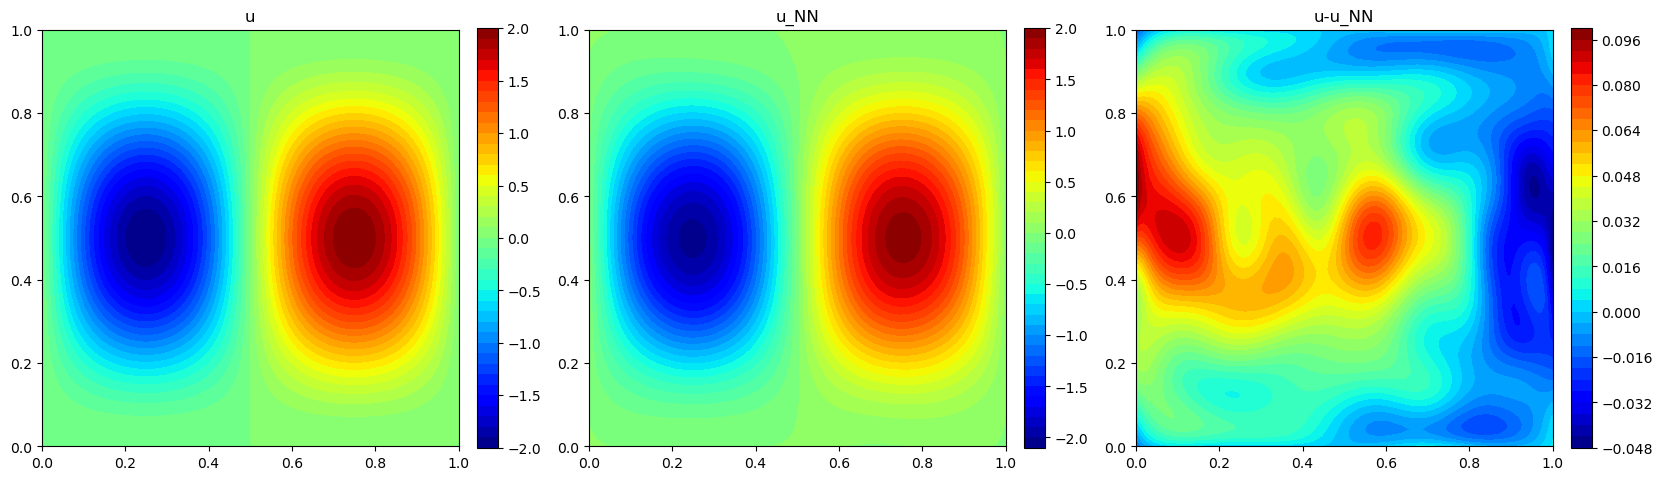

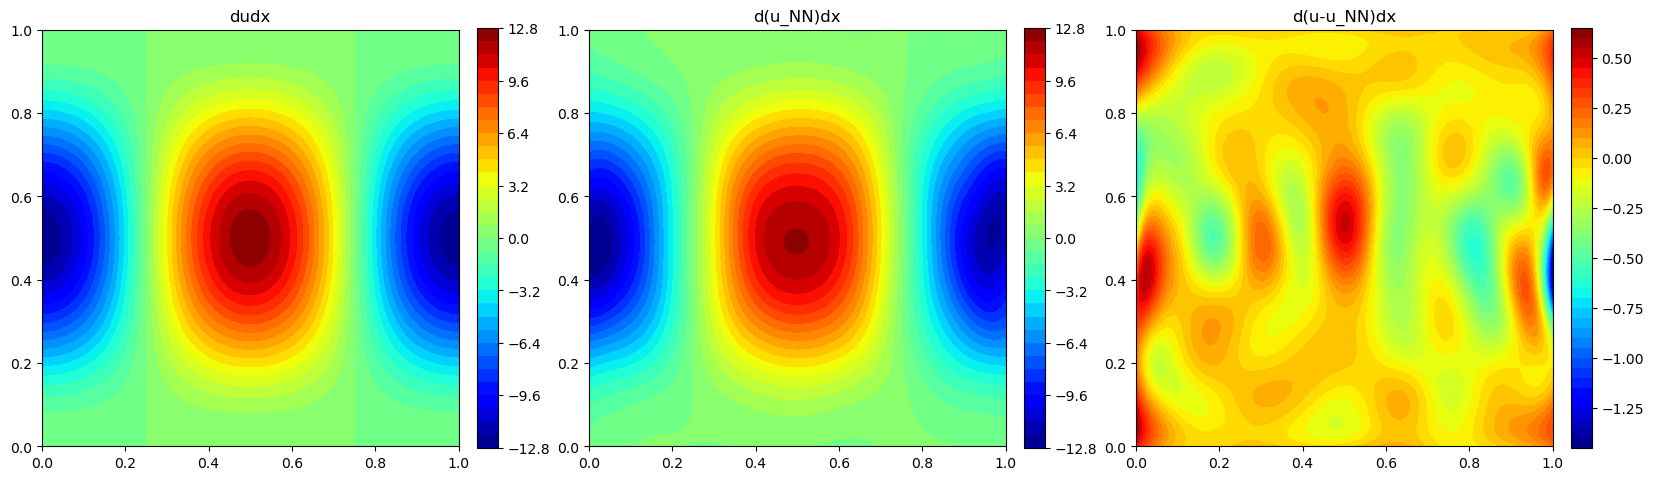

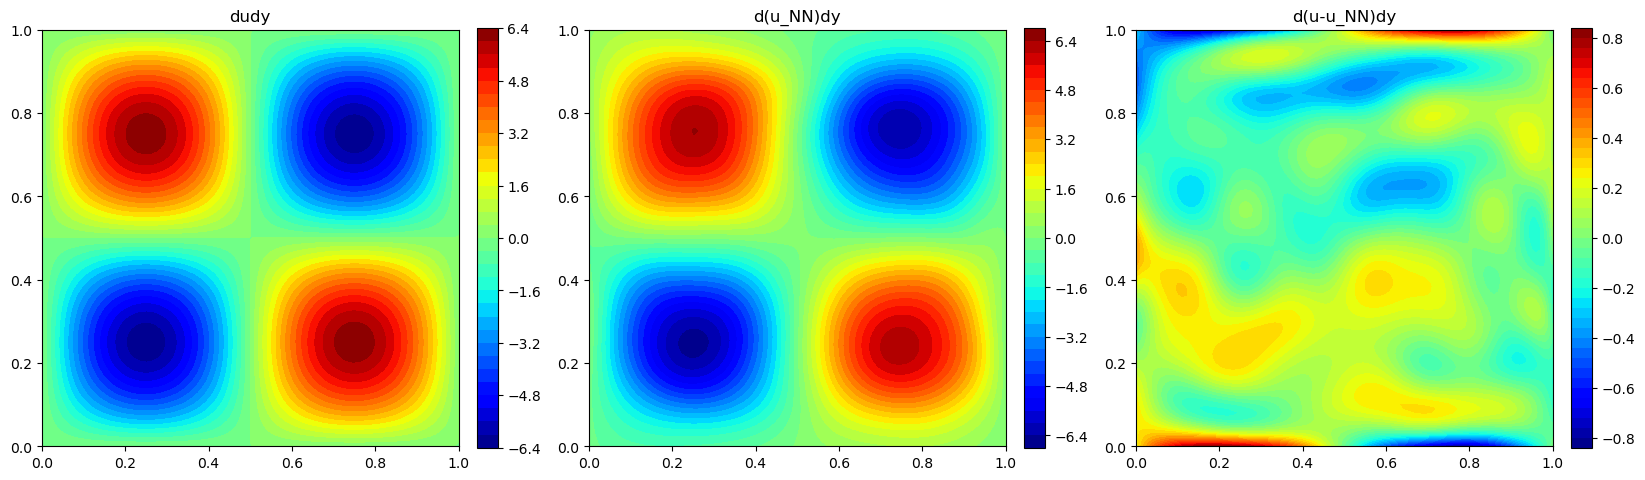

* --------------------------------------------- * 
 



In [5]:
print('*', '-' * 45, '*')
print('===> loading trained model for inference ...')

# compute NN predicution of u and gradu
with torch.no_grad():    
    SmpPts_Test = testdata.SmpPts_Test
    SmpPts_Test = SmpPts_Test.to(device)
    u_NN = model(SmpPts_Test) 

SmpPts_Test.requires_grad = True
u_NN_Test = model(SmpPts_Test)
model.zero_grad()
gradu_NN_test = torch.autograd.grad(outputs=u_NN_Test, inputs=SmpPts_Test, grad_outputs=torch.ones_like(u_NN_Test), retain_graph=True, create_graph=True, only_inputs=True)[0]

x = testdata.SmpPts_Test[:,0].reshape(num_test_pts,num_test_pts)
y = testdata.SmpPts_Test[:,1].reshape(num_test_pts,num_test_pts)

with torch.no_grad(): 
    # plot u and its network prediction on testing dataset
    fig1 = plt.figure(figsize=(20, 6), dpi= 100)
    plt.subplot(1, 3, 1)
    u_Exact = testdata.u_Exact_SmpPts.reshape(num_test_pts,num_test_pts)
    plt.contourf(x, y, u_Exact, 40, cmap = 'jet')
    plt.title('u')
    plt.axis([0, 1, 0, 1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1, 3, 2)
    u_NN = u_NN.reshape(num_test_pts, num_test_pts)    
    plt.contourf(x, y, u_NN, 40, cmap = 'jet')
    plt.title('u_NN')
    plt.axis([0, 1, 0, 1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1, 3, 3)
    u_Exact = testdata.u_Exact_SmpPts.reshape(num_test_pts,num_test_pts)
    err = u_Exact - u_NN
    plt.contourf(x, y, err, 40, cmap = 'jet')
    plt.title('u-u_NN')
    plt.axis([0, 1, 0, 1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(fraction=0.046, pad=0.04)    
    plt.show() 

        
    # plot dudx and its network prediction on testing dataset
    fig2 = plt.figure(figsize=(20, 6), dpi= 100)
    plt.subplot(1, 3, 1)    
    dudx_Exact = testdata.dudx_Exact_SmpPts.reshape(num_test_pts,num_test_pts)
    plt.contourf(x, y, dudx_Exact, 40, cmap = 'jet')
    plt.title('dudx')
    plt.axis([0, 1, 0, 1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1, 3, 2) 
    dudx_NN_test = gradu_NN_test[:,0].detach().numpy().reshape(num_test_pts,num_test_pts)
    plt.contourf(x, y, dudx_NN_test, 40, cmap = 'jet')
    plt.title('d(u_NN)dx')
    plt.axis([0, 1, 0, 1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1, 3, 3) 
    plt.contourf(x, y, dudx_Exact - dudx_NN_test, 40, cmap = 'jet')
    plt.title('d(u-u_NN)dx')
    plt.axis([0, 1, 0, 1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()  
    
    # plot gradu_y and its network prediction on testing dataset
    fig3 = plt.figure(figsize=(20, 8), dpi= 100)
    plt.subplot(1, 3, 1) 
    dudy_Exact = testdata.dudy_Exact_SmpPts.reshape(num_test_pts,num_test_pts)
    plt.contourf(x, y, dudy_Exact, 40, cmap = 'jet')
    plt.title('dudy')
    plt.axis([0, 1, 0, 1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1, 3, 2) 
    dudy_NN_test = gradu_NN_test[:,1].detach().numpy().reshape(num_test_pts,num_test_pts)
    plt.contourf(x, y, dudy_NN_test, 40, cmap = 'jet')
    plt.title('d(u_NN)dy')
    plt.axis([0, 1, 0, 1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.subplot(1, 3, 3) 
    plt.contourf(x, y, dudy_Exact - dudy_NN_test, 40, cmap = 'jet')
    plt.title('d(u-u_NN)dy')
    plt.axis([0, 1, 0, 1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()
        
print('*', '-' * 45, '*', "\n", "\n")
##############################################################################################

## 4. 课后作业（Talk is cheap. Show me the code.）

### 小组作业 1（正问题）
- 用机器学习方法实现基于 Galerkin 形式的 Poisson 方程求解。
     
- 参考资料：[Weak adversarial networks for high-dimensional partial differential equations](https://www.sciencedirect.com/science/article/abs/pii/S0021999120301832)。
  
### 小组作业 2（正问题）
- 混合变分原理 **（complementary energy）：** 通过引入新的变量 $\nabla u(x) = \overrightarrow{\sigma}(x) = (\sigma_1(x), \sigma_2(x))^T$，经典的 Poisson 方程

\begin{equation*}
\begin{array}{cl}
- \Delta u(x) = f(x)\ \ & \text{in}\ \Omega,\\
u(x)=0\ \ & \text{on}\ \partial \Omega,
\end{array}
\end{equation*}

$~~~~~~$ 可以改写为等价形式

\begin{equation*}
\begin{array}{cl}
\overrightarrow{\sigma}(x)=\nabla u(x)\ \ & \text{in}\ \Omega,\\
- \nabla \cdot \overrightarrow{\sigma}(x) = f(x)\ \ & \text{in}\ \Omega,\\
u(x)=0\ \ & \text{on}\ \partial \Omega.
\end{array}
\end{equation*}

$~~~~~~$ 特别的，根据混合变分原理，$\sigma(x)$ 是如下变分问题的最优解

\begin{equation*}
	\min_{ \overrightarrow{\sigma} \in W^f } \frac12 \int_\Omega \Big( \sigma_1^2 + \sigma_2^2 \Big)dx \ \ \text{其中函数空间}\ W^f = \Big\{ \overrightarrow{q}\in H(\text{div},\Omega) \, | \, \nabla \cdot \overrightarrow{q} + f = 0 \ \text{in}\ \Omega \Big\}.
\end{equation*}

试着比较上述方法与 PINNs、Deep Ritz 方法在数值近似未知函数梯度时的优劣。
     
- 参考资料：[Numerical Approximation of Partial Differential Equations, Chapter 7](https://link.springer.com/chapter/10.1007/978-3-540-85268-1_7)。

  
